<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_06_auto_ml_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Tuning

In [0]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v3'

In [2]:
if COLAB:
  !pip install -U imblearn
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects

Requirement already up-to-date: imblearn in /usr/local/lib/python3.6/dist-packages (0.0)
Cloning into 'dl-projects'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 1240 (delta 94), reused 16 (delta 8), pack-reused 1089
Receiving objects: 100% (1240/1240), 74.95 MiB | 12.99 MiB/s, done.
Resolving deltas: 100% (739/739), done.


In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .

In [0]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import matplotlib
import sys

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

import featuretools as ft

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, make_scorer, recall_score, roc_curve, mean_squared_error, accuracy_score, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.decomposition import PCA
import pylab as pl
from collections import Counter

# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

# from sklearn.ensemble import RandomForestClassifier

# from scikitplot.plotters import plot_precision_recall_curve

from dateutil.relativedelta import relativedelta

from IPython.display import display

from utils import *
from preprocess import *

import xgboost as xgb

np.set_printoptions(threshold=sys.maxsize)

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

from utils import feature_selection, plot_feature_importances
from plot import plot_correlation_matrix, plot_labeled_scatter


from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     AllKNN,
                                     NearMiss)
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN

In [6]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [7]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.ft"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 5586M
-rw------- 1 root root 1548M Jan  7 00:07 feature_matrix_d2_v1.pkl
-rw------- 1 root root 2454M Jan 12 01:24 feature_matrix_d2_v2.ft
-rw------- 1 root root 1585M Jan 12 23:39 feature_matrix_d2_v3.ft
total 25M
-rw-r--r-- 1 root root  1M Jan 21 23:04 4D.zip
-rw-r--r-- 1 root root 25M Jan 21 23:04 labels.csv


In [0]:
data = pd.read_feather(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

## Exploratory Data Analysis

### View data

In [0]:
# Feature matrix
feature_matrix = data.drop(columns=['NumberId', 'month', 'year'])

In [11]:
# Sort data
feature_matrix.sort_values(by=['time', 'MAX(Results.LuckyNo)'], inplace=True)
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959893 entries, 7020 to 956511
Columns: 214 entries, time to LAST(Results.PrizeType)_Prize
dtypes: datetime64[ns](1), float64(155), int64(56), uint8(2)
memory usage: 1.5 GB


In [12]:
print('Distrbution')
print(feature_matrix['Label'].value_counts())
print()
print('Positive: ' + str(feature_matrix['Label'].value_counts()[0]) + ' which is ', round(feature_matrix['Label'].value_counts()[0]/len(feature_matrix) * 100,2), '% of the dataset')
print('Negative: ' + str(feature_matrix['Label'].value_counts()[1]) + ' which is ', round(feature_matrix['Label'].value_counts()[1]/len(feature_matrix) * 100,2), '% of the dataset')

Distrbution
0    927839
1     32054
Name: Label, dtype: int64

Positive: 927839 which is  96.66 % of the dataset
Negative: 32054 which is  3.34 % of the dataset


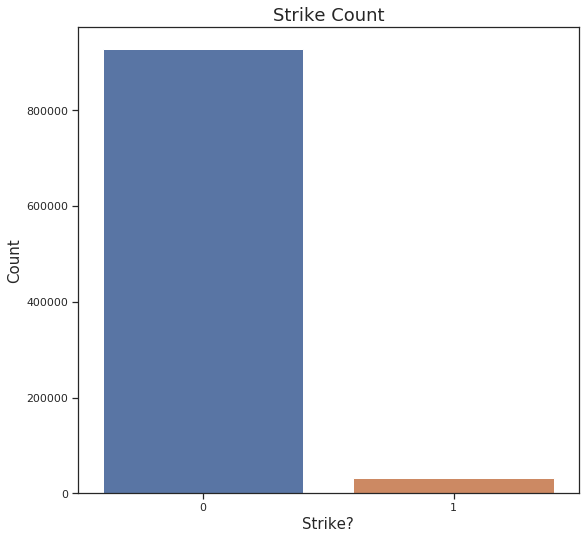

In [13]:
plt.figure(figsize=(8, 8))
sns.countplot('Label', data=feature_matrix)
plt.title("Strike Count", fontsize=18)
plt.xlabel("Strike?", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

In [14]:
feature_matrix.isna().sum().sort_values(ascending=False)

SKEW(Results.TIME_SINCE_PREVIOUS(DrawDate))               7636
CUM_MEAN(TREND(Results.LuckyNo, DrawDate))                7636
TREND(Results.TIME_SINCE_PREVIOUS(DrawDate), DrawDate)    7636
TREND(Results.CUM_MEAN(TotalStrike), DrawDate)            7636
TREND(Results.CUM_SUM(LuckyNo), DrawDate)                 7636
                                                          ... 
CUM_SUM(MIN(Results.DrawNo))                                 0
NUM_UNIQUE(Results.DAY(DrawDate))                            0
NUM_UNIQUE(Results.MONTH(DrawDate))                          0
SUM(Results.PERCENTILE(LuckyNo))                             0
time                                                         0
Length: 214, dtype: int64

In [15]:
feature_matrix[feature_matrix.isnull().any(axis=1)].head()

,time,STD(Results.DrawNo),STD(Results.TotalStrike),STD(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MAX(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MIN(Results.LuckyNo),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),MEAN(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),LAST(Results.DrawNo),LAST(Results.TotalStrike),LAST(Results.LuckyNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.TotalStrike),SUM(Results.LuckyNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.TIME_SINCE(DrawDate)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),STD(Results.TIME_SINCE_PREVIOUS(DrawDate)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.PERCENTILE(TotalStrike)),...,CUM_MEAN(SUM(Results.TotalStrike)),CUM_MEAN(STD(Results.TotalStrike)),CUM_MEAN(SKEW(Results.TotalStrike)),CUM_MEAN(SUM(Results.DrawNo)),"CUM_MEAN(TREND(Results.DrawNo, DrawDate))",CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(MAX(Results.LuckyNo)),MONTH(LAST(Results.DrawDate)),DAY(LAST(Results.DrawDate)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(MAX(Results.TotalStrike)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(SKEW(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(SUM(Results.DrawNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(MAX(Results.LuckyNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize
363,2012-01-01,101777.042238,0.0,0.0,323109,1,19,40792,1,19,178621.785714,1,19,0.070113,0.0,0.0,64949,323109,1,19,4.214991e+07,14,2500705,14,266,0.0,0.0,0.03093,1,5,6,620265540.0,NaN,1.974207e+08,50881.655504,1.165405e+08,0.315275,23963.048477,23409.008640,0.0,...,14.000000,0.0,0.0,2.500705e+06,0.03093,19.000000,19.000000,9,16,0.500051,0.001201,0.256328,0.50005,0.392496,0.50005,0.500051,0.50005,0.50005,0.056537,0.002001,0.392496,0.985643,0.002001,0.004502,0.50005,0.50005,0.696425,0.548813,0.500051,0.985643,0.50005,0.500051,0.937769,0.200471,0.002001,0.002001,0.0,0,1,1
9017,2012-01-01,126014.206582,0.0,0.0,317909,1,123,139698,1,123,228803.500000,1,123,NaN,NaN,NaN,63742,317909,1,123,3.393792e+08,2,457607,2,246,NaN,NaN,NaN,1,8,29,421027140.0,259200.0,2.399773e+08,63009.063553,1.443593e+08,0.390354,0.000000,28985.721174,0.0,...,7.681889,0.0,NaN,1.524155e+06,NaN,5002.374694,5002.374694,5,31,NaN,0.898299,0.772186,0.50005,0.348174,0.50005,NaN,0.50005,0.50005,0.996485,0.012406,0.348174,0.013057,0.012406,0.003902,0.50005,0.50005,0.962392,NaN,NaN,0.013057,0.50005,NaN,0.026213,NaN,0.012406,0.012406,0.0,0,1,1
8619,2012-01-01,139944.917278,0.0,0.0,322109,1,135,124197,1,135,223153.000000,1,135,NaN,NaN,NaN,64702,322109,1,135,3.782592e+08,2,446306,2,270,NaN,NaN,NaN,1,8,31,452390340.0,0.0,2.674696e+08,69939.255825,1.603340e+08,0.433508,0.000000,32173.358544,0.0,...,7.738201,0.0,NaN,1.524989e+06,NaN,4988.969509,4988.969509,8,26,NaN,0.856378,0.721761,0.50005,0.383192,0.50005,NaN,0.50005,0.50005,0.997791,0.013607,0.383192,0.013057,0.013607,0.004702,0.50005,0.50005,0.990259,

### Data Cleansing

In [0]:
## Fill all NaN with 0
feature_matrix = feature_matrix.fillna(0)

In [17]:
feature_matrix.isna().sum().sort_values(ascending=False)

LAST(Results.PrizeType)_Prize                  0
SKEW(Results.TIME_SINCE(DrawDate))             0
MEAN(Results.CUM_MEAN(TotalStrike))            0
MEAN(Results.CUM_MEAN(LuckyNo))                0
MEAN(Results.CUM_SUM(DrawNo))                  0
                                              ..
CUM_SUM(COUNT(Results))                        0
CUM_SUM(MAX(Results.DrawNo))                   0
CUM_SUM(MEAN(Results.LuckyNo))                 0
CUM_SUM(AVG_TIME_BETWEEN(Results.DrawDate))    0
time                                           0
Length: 214, dtype: int64

In [18]:
feature_matrix[feature_matrix.isnull().any(axis=1)].head()

,time,STD(Results.DrawNo),STD(Results.TotalStrike),STD(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MAX(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MIN(Results.LuckyNo),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),MEAN(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),LAST(Results.DrawNo),LAST(Results.TotalStrike),LAST(Results.LuckyNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.TotalStrike),SUM(Results.LuckyNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.TIME_SINCE(DrawDate)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),STD(Results.TIME_SINCE_PREVIOUS(DrawDate)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.PERCENTILE(TotalStrike)),...,CUM_MEAN(SUM(Results.TotalStrike)),CUM_MEAN(STD(Results.TotalStrike)),CUM_MEAN(SKEW(Results.TotalStrike)),CUM_MEAN(SUM(Results.DrawNo)),"CUM_MEAN(TREND(Results.DrawNo, DrawDate))",CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(MAX(Results.LuckyNo)),MONTH(LAST(Results.DrawDate)),DAY(LAST(Results.DrawDate)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(MAX(Results.TotalStrike)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(SKEW(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(SUM(Results.DrawNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(MAX(Results.LuckyNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize


In [0]:
# Feature Distribution

# plt.figure(figsize=(16,4))
# feature_matrix.iloc[:,:-1].boxplot()
# plt.title('(Raw) Distribution of Features', fontsize=17)
# plt.show()

# plt.figure(figsize=(16,4))
# np.log(feature_matrix.drop(columns=['time']).iloc[:,:-1]).boxplot() # Remove time column
# plt.title('(Log) Distribution of Features', fontsize=17)
# plt.show()

### Feature Selection

In [0]:
# Feature scaling first??

In [21]:
print(feature_matrix.shape)
feature_matrix.columns

(959893, 214)


Index(['time', 'STD(Results.DrawNo)', 'STD(Results.TotalStrike)',
       'STD(Results.LuckyNo)', 'MAX(Results.DrawNo)',
       'MAX(Results.TotalStrike)', 'MAX(Results.LuckyNo)',
       'MIN(Results.DrawNo)', 'MIN(Results.TotalStrike)',
       'MIN(Results.LuckyNo)',
       ...
       'PERCENTILE(STD(Results.TotalStrike))',
       'PERCENTILE(SKEW(Results.TotalStrike))',
       'PERCENTILE(SUM(Results.DrawNo))',
       'PERCENTILE(TREND(Results.DrawNo, DrawDate))',
       'PERCENTILE(LAST(Results.LuckyNo))', 'PERCENTILE(MAX(Results.LuckyNo))',
       'TotalStrike', 'Label', 'MODE(Results.PrizeType)_Prize',
       'LAST(Results.PrizeType)_Prize'],
      dtype='object', length=214)

In [22]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label']))

Original shape:  (959893, 211)
0 missing columns with threshold: 90.
41 zero variance columns.
109 collinear columns removed with threshold: 0.95.
Total columns removed:  150
Shape after feature selection: (959893, 61).


In [23]:
feature_matrix_selection.shape, feature_matrix_selection.columns

((959893, 61),
 Index(['STD(Results.DrawNo)', 'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
        'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)', 'SKEW(Results.DrawNo)',
        'AVG_TIME_BETWEEN(Results.DrawDate)', 'COUNT(Results)',
        'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
        'TREND(Results.DrawNo, DrawDate)', 'MONTH(first_Results_time)',
        'DAY(first_Results_time)', 'TIME_SINCE(first_Results_time)',
        'TIME_SINCE_PREVIOUS(first_Results_time)',
        'STD(Results.PERCENTILE(DrawNo))',
        'STD(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'STD(Results.CUM_SUM(DrawNo))', 'STD(Results.CUM_MEAN(LuckyNo))',
        'MAX(Results.PERCENTILE(DrawNo))',
        'MAX(Results.PERCENTILE(TotalStrike))',
        'MAX(Results.CUM_MEAN(LuckyNo))',
        'MIN(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'MIN(Results.CUM_MEAN(LuckyNo))', 'MODE(Results.MONTH(DrawDate))',
        'MODE(Results.DAY(DrawDate))', 'MEAN(Results.TIME_SINCE(DrawDate))',
       

In [0]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['TotalStrike'] = feature_matrix['TotalStrike']
feature_matrix_selection['Label'] = feature_matrix['Label']

### Feature Correlation

In [0]:
# Check without feature selection
# corrs = feature_matrix.corr().sort_values('Label')
# corrs['Label'].tail(100)

In [26]:
# Check with feature selection
corrs = feature_matrix_selection.corr().sort_values('Label')
corrs['Label'].tail(20)

SUM(Results.TIME_SINCE_PREVIOUS(DrawDate))      0.000442
MODE(Results.DAY(DrawDate))                     0.000471
PERCENTILE(SUM(Results.DrawNo))                 0.000610
TREND(Results.PERCENTILE(LuckyNo), DrawDate)    0.000687
MONTH(first_Results_time)                       0.000858
PERCENTILE(TREND(Results.DrawNo, DrawDate))     0.000912
MIN(Results.TIME_SINCE_PREVIOUS(DrawDate))      0.000984
TIME_SINCE_PREVIOUS(first_Results_time)         0.000987
LAST(Results.CUM_MEAN(LuckyNo))                 0.000988
MAX(Results.CUM_MEAN(LuckyNo))                  0.001007
MEAN(Results.PERCENTILE(DrawNo))                0.001149
TREND(Results.CUM_MEAN(LuckyNo), DrawDate)      0.001493
TREND(Results.PERCENTILE(DrawNo), DrawDate)     0.001528
PERCENTILE(MAX(Results.TotalStrike))            0.001564
MIN(Results.DrawNo)                             0.001718
CUM_SUM(MIN(Results.DrawNo))                    0.001852
MAX(Results.PERCENTILE(TotalStrike))            0.002320
STD(Results.CUM_MEAN(LuckyNo)) 

### Feature Distributions

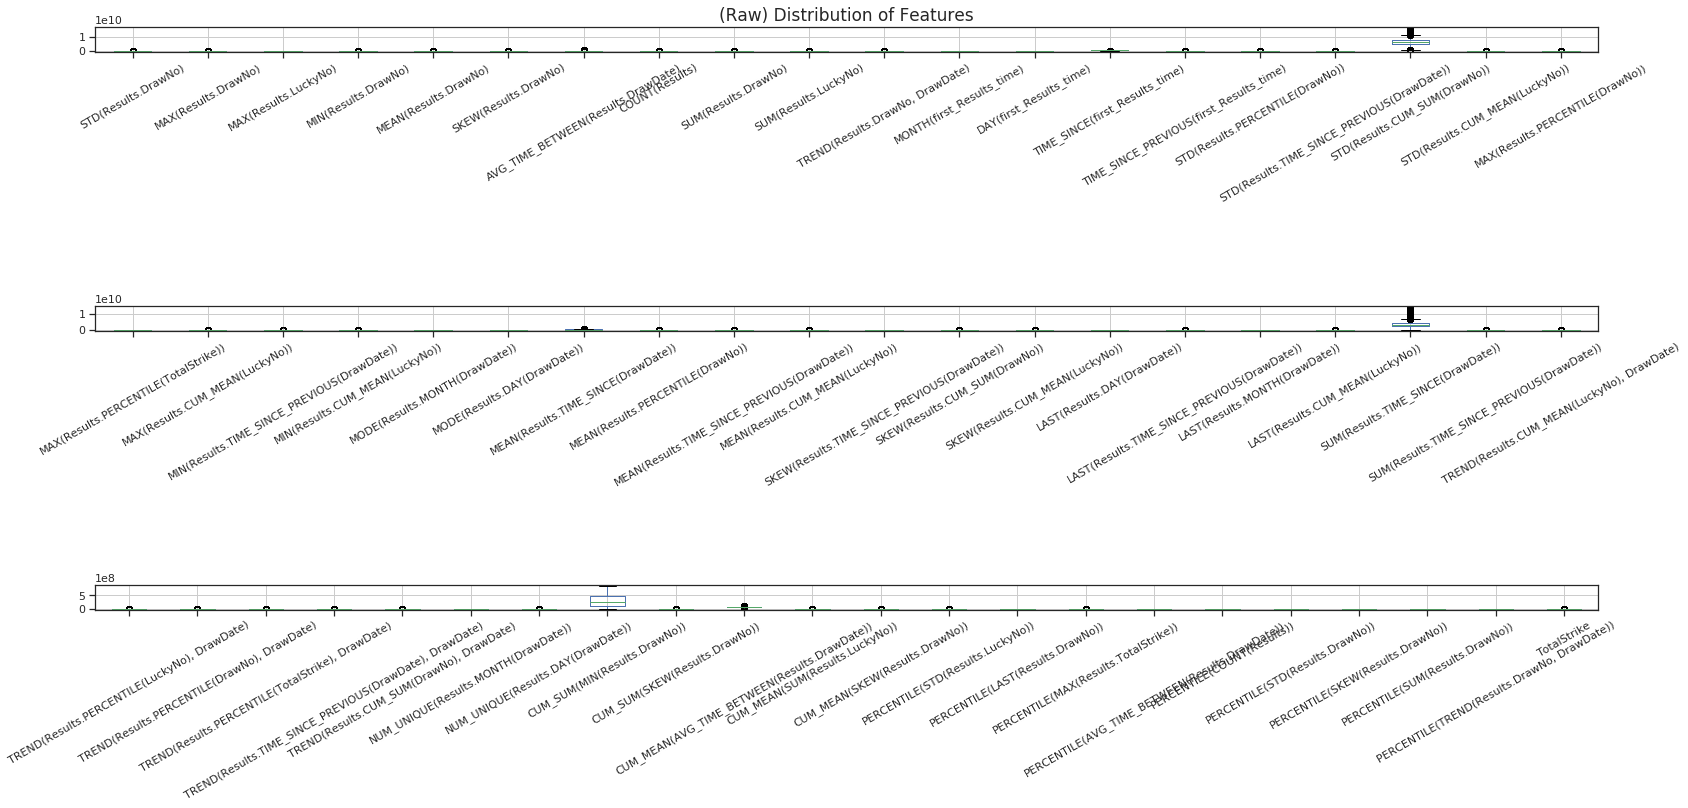

In [27]:
fig = plt.figure(figsize=(24,10))
fig.tight_layout()
fig.subplots_adjust(wspace=1)
plt.subplot(311)
ax = feature_matrix_selection.iloc[:,:20].boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.title('(Raw) Distribution of Features', fontsize=17)

plt.subplot(312)
ax = feature_matrix_selection.iloc[:,20:40].boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

plt.subplot(313)
ax = feature_matrix_selection.iloc[:,40:-1].boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

fig.subplots_adjust(hspace=10)
plt.show()

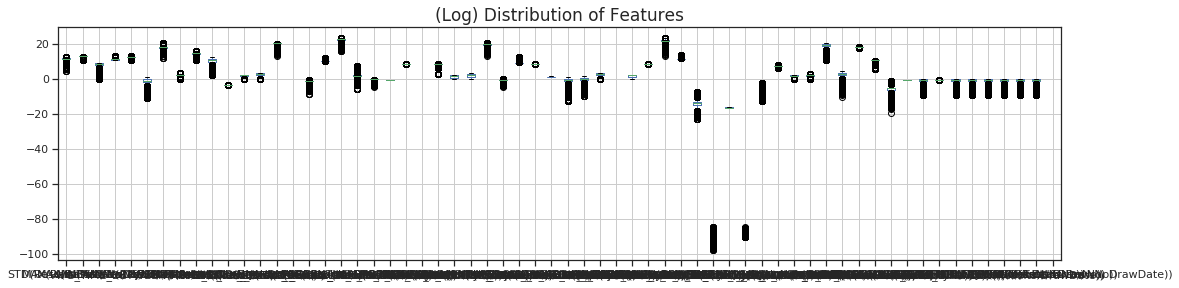

In [28]:
plt.figure(figsize=(16,4))
np.log(feature_matrix_selection.drop(columns=['time']).iloc[:,:-1]).boxplot() # Remove time column
plt.title('(Log) Distribution of Features', fontsize=17)
plt.show()

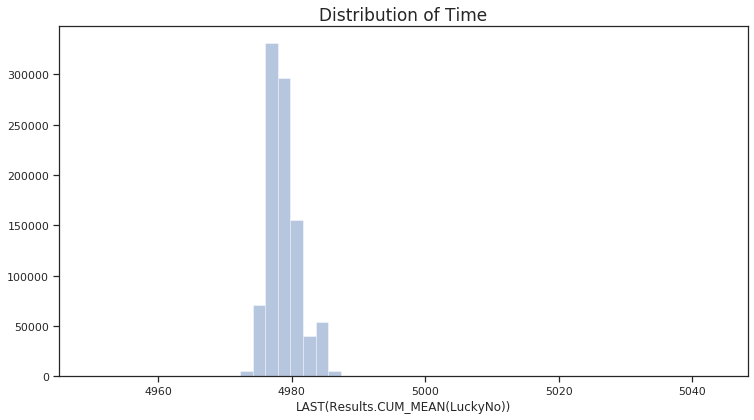

In [29]:
plt.figure(figsize=(11,6))
sns.distplot(feature_matrix_selection['LAST(Results.CUM_MEAN(LuckyNo))'],kde=False)
plt.title('Distribution of Time', fontsize=17)
plt.show()

## Modeling

In [0]:
## Baseline - https://www.kaggle.com/miguelniblock/optimizing-imbalanced-classification-100-recall
def predict_baseline(dt, feature_matrix): 
    
    feature_matrix['date'] = feature_matrix['time']

    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['date'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['date'] < dt, 'Label']

    # Features
    X_train = feature_matrix[feature_matrix['date'] < dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['date'] == dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    feature_names = list(X_train.columns)
    
    if type(train_labels) == np.ndarray:
      hit_ratio = float( len(np.where(train_labels == 0)[0]) / len(np.where(train_labels == 1)[0]) ) 
    else:
      hit_ratio = float(train_labels.value_counts()[0]/train_labels.value_counts()[1]) 
    
    print(f"Hit ratio before balancing - {hit_ratio}\n")

    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
  
    pipeline = make_pipeline_imb(
                                SimpleImputer(strategy = 'constant', fill_value=0),
                                StandardScaler()
                                )
    
   
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)

    # Create the classifier
    clf = xgb.XGBClassifier(
                             n_jobs=4, 
                             random_state = 42,
                            #  n_estimators=300, 
                            #  max_depth=5,
                            n_estimators=100, 
                            max_depth=3,
                            # n_estimators=1000, 
                            #  max_depth=5,
                            #  gamma=0,
                            #  subsample=0.8,
                            #  colsample_bytree=0.8,
                            #  learning_rate=0.1,
                             objective='binary:logistic',
                             min_child_weight=1,
                             scale_pos_weight=hit_ratio 
                             )
    
    # Make a scoring callable from recall_score
    recall = make_scorer(recall_score)

    train_cv = cross_val_score(X=X_train,y=y_train, scoring=recall, estimator=clf,cv=3)
    print("TRAIN GROUP")
    print("\nCross-validation recall scores:",train_cv)
    print("Mean recall score:",train_cv.mean())

    # Now predict on the test group
    print("\nTEST GROUP")
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    print("\nRecall:",recall_score(y_test,y_pred))

    # Classification report
    print('\nClassification report:\n')
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
    plt.show()


In [0]:
#predict_baseline(pd.datetime(2019,6,1), feature_matrix_selection)

### Balancing Data

In [0]:
def predict_imbalanced(dt, feature_matrix): 
    
    feature_matrix['date'] = feature_matrix['time']

    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['date'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['date'] < dt, 'Label']

    # Features
    X_train = feature_matrix[feature_matrix['date'] < dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['date'] == dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    feature_names = list(X_train.columns)
    
    if type(train_labels) == np.ndarray:
      hit_ratio = float( len(np.where(train_labels == 0)[0]) / len(np.where(train_labels == 1)[0]) ) 
    else:
      hit_ratio = float(train_labels.value_counts()[0]/train_labels.value_counts()[1]) 
    
    print(f"Hit ratio before balancing - {hit_ratio}\n")

    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
  
    # Join the train data
    train = X_train.join(train_labels)

    print('Data shape before balancing:',train.shape)
    print('\nCounts of strikes VS non-strikes in previous data:')
    print(train.Label.value_counts())
    print('-'*40)

    # Balancing the test data
    pipeline = make_pipeline_imb(
                                SimpleImputer(strategy = 'constant', fill_value=0),
                                StandardScaler(),
                                SMOTE(sampling_strategy='minority',random_state=42, n_jobs=4)
                                )
    X_bal, y_bal = pipeline.fit_resample(X_train, y_train)
    X_bal = pd.DataFrame(X_bal,columns=X_train.columns)
    y_bal = pd.DataFrame(y_bal,columns=['Label'])
    balanced = X_bal.join(y_bal)

    print('-'*40)
    print('Data shape after balancing:',balanced.shape)
    print('\nCounts of strikes VS non-strikes in new data:')
    print(balanced.Label.value_counts())

    print('Distribution of the Classes in the subsample dataset')
    print(balanced.Label.value_counts()/len(train))

    sns.countplot('Label', data=balanced)
    plt.title('Label Distribution', fontsize=14)
    plt.show()

    # Compare correlation of raw train data VS balanced train data
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

    # Imbalanced DataFrame
    corr = train.corr()
    # sns.heatmap(corr, annot_kws={'size':20}, ax=ax1)
    # ax1.set_title("Imbalanced Correlation Matrix \n (Biased)", fontsize=14)

    # Balanced DataFrame
    bal_corr = balanced.corr()
    # sns.heatmap(bal_corr, annot_kws={'size':20}, ax=ax2)
    # ax2.set_title('Balanced Correlation Matrix', fontsize=14)
    # plt.show()

    # Each feature's correlation with Class
    print(bal_corr.Label)

    no_outliers=pd.DataFrame(balanced.copy())

    # Removing Outliers from high-correlation features

    cols = bal_corr.Label.index[:-1]

    # For each feature correlated with Class...
    for col in cols:
        # If absolute correlation value is more than X percent...
        correlation = bal_corr.loc['Label',col]

        if np.absolute(correlation) > 0.1:
          # Separate the classes of the high-correlation column
          nonstrikes = no_outliers.loc[no_outliers.Label==0,col]
          strikes = no_outliers.loc[no_outliers.Label==1,col]

          # Identify the 25th and 75th quartiles
          all_values = no_outliers.loc[:,col]
          q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
          # Get the inter quartile range
          iqr = q75 - q25
          # Smaller cutoffs will remove more outliers
          cutoff = iqr * 7
          # Set the bounds of the desired portion to keep
          lower, upper = q25 - cutoff, q75 + cutoff
          
          # If positively correlated...
          # Drop nonstrikes above upper bound, and strikes below lower bound
          if correlation > 0: 
              no_outliers.drop(index=nonstrikes[nonstrikes>upper].index,inplace=True)
              no_outliers.drop(index=strikes[strikes<lower].index,inplace=True)
          
          # If negatively correlated...
          # Drop non strikes below lower bound, and strikes above upper bound
          elif correlation < 0: 
              no_outliers.drop(index=nonstrikes[nonstrikes<lower].index,inplace=True)
              no_outliers.drop(index=strikes[strikes>upper].index,inplace=True)
        
    print('\nData shape before removing outliers:', balanced.shape)
    print('\nCounts of strikes VS non-strikes in previous data:')
    print(balanced.Label.value_counts())
    print('-'*40)
    print('-'*40)
    print('\nData shape after removing outliers:', no_outliers.shape)
    print('\nCounts of strikes VS non-strikes in new data:')
    print(no_outliers.Label.value_counts())

    no_outliers.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
    plt.title('Distributions with Less Outliers', fontsize=17)
    plt.show()


    # Feature selection
    feat_sel =pd.DataFrame(no_outliers.copy())

    # Make a dataframe with the label-correlations before removing outliers
    corr_change = pd.DataFrame()
    corr_change['correlation']= bal_corr.Label
    corr_change['origin']= 'w/outliers'

    # Make a dataframe with label-correlations after removing outliers 
    corr_other = pd.DataFrame()
    corr_other['correlation']= feat_sel.corr().Label
    corr_other['origin']= 'no_outliers'

    # Join them
    corr_change = corr_change.append(corr_other)

    plt.figure(figsize=(14,6))
    plt.xticks(rotation=90)

    # Plot them
    sns.set_style('darkgrid')
    plt.title('Label Correlation per Feature. With VS W/out Outliers', fontsize=17)
    sns.barplot(data=corr_change,x=corr_change.index,y='correlation',hue='origin')
    plt.show()

    # Feature Selection based on correlation with Class
    print('\nData shape before feature selection:', feat_sel.shape)
    print('\nCounts of strikes VS non-strikes before feature selection:')
    print(feat_sel.Label.value_counts())
    print('-'*40)

    # Correlation matrix after removing outliers
    # new_corr = feat_sel.corr()

    # for col in new_corr.Label.index[:-1]:
    #     # Pick desired cutoff for dropping features. In absolute-value terms.
    #     if np.absolute(new_corr.loc['Label',col]) < 0.1:
    #         # Drop the feature if correlation is below cutoff
    #         feat_sel.drop(columns=col,inplace=True)

    # print('-'*40)
    # print('\nData shape after feature selection:', feat_sel.shape)
    # print('\nCounts of strikes VS non-strikes in new data:')
    # print(feat_sel.Label.value_counts())

    # feat_sel.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
    # plt.title('Distribution of Features Selected', fontsize=17)
    # plt.show()

    X_train = feat_sel.drop('Label',1)
    y_train = feat_sel.Label

    # After feature-selection, X_test needs to include only the same features as X_train
    cols = X_train.columns
    X_test = X_test[cols]

    # Undersample and balance classes
    X_train, y_train = RandomUnderSampler(sampling_strategy={1:100000,0:100000}, random_state=42).fit_resample(X_train,y_train)

    print('\nX_train shape after reduction:', X_train.shape)
    print('\nCounts of strikes VS non-strikes in y_train:')
    print(np.unique(y_train, return_counts=True))

    # First-Run: Predictions on Default Parameters
    performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])

    # Load simple classifiers
    classifiers = [
                   SVC(max_iter=1000),
                   LogisticRegression(),
                   DecisionTreeClassifier(),
                   KNeighborsClassifier(),
                   xgb.XGBClassifier(n_jobs=4, random_state = 42,objective='binary:logistic')
                   ]

    
    # Make a scoring callable from recall_score
    recall = make_scorer(recall_score)

    # Get a classification report from each algorithm
    for clf in classifiers:    
    
      # Heading
      print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)
      
      # Cross-validate on the train data
      print("TRAIN GROUP")
      train_cv = cross_val_score(X=X_train, y=y_train, 
                                estimator=clf, scoring=recall,cv=3)
      print("\nCross-validation recall scores:",train_cv)
      print("Mean recall score:",train_cv.mean())

      # Now predict on the test group
      print("\nTEST GROUP")
      y_pred = clf.fit(X_train, y_train).predict(X_test)
      print("\nRecall:",recall_score(y_test,y_pred))
      
      # Print confusion matrix
      conf_matrix = confusion_matrix(y_test,y_pred)
      sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
      plt.show()
      
      # Store results
      performance.loc[clf.__class__.__name__+'_default',
                      ['Train_Recall','Test_Recall','Test_Specificity']] = [
          train_cv.mean(),
          recall_score(y_test,y_pred),
          conf_matrix[0,0]/conf_matrix[0,:].sum()
      ]



In [0]:
%time predict_imbalanced(pd.datetime(2019,6,1), feature_matrix_selection)

Hit ratio before balancing - 28.829148929038315

Training on 889893 observations.
Testing on 10000 observations.

Data shape before balancing: (889893, 62)

Counts of strikes VS non-strikes in previous data:
0    860060
1     29833
Name: Label, dtype: int64


In [43]:
X = feature_matrix_selection..drop(columns = ['NumberId', 'time','date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
y = feature_matrix_selection.Label
counter = Counter(y)
print(counter)

NameError: ignored

In [0]:
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = np.where(y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [0]:
# def predict_imb(dt, feature_matrix): 
#     """
#     Reference:
#       - https://xgboost.readthedocs.io/en/latest/parameter.html
#       - https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
#       - https://stats.stackexchange.com/questions/224512/reduce-false-positives-with-xgboost
#       - https://stackoverflow.com/questions/52499788/smotetomek-how-to-set-ratio-as-dictionary-for-fixed-balance
#       - https://github.com/coding-maniacs/over-under-sampling/blob/master/src/main.py
#     """
#     feature_matrix['date'] = feature_matrix['time']

#     # Subset labels
#     test_labels = feature_matrix.loc[feature_matrix['date'] == dt, 'Label']
#     train_labels = feature_matrix.loc[feature_matrix['date'] < dt, 'Label']

#     # Features
#     X_train = feature_matrix[feature_matrix['date'] < dt].drop(columns = ['NumberId', 'time',
#                                                                                      'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
#     X_test = feature_matrix[feature_matrix['date'] == dt].drop(columns = ['NumberId', 'time',
#                                                                                      'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
#     feature_names = list(X_train.columns)
    
#     if type(train_labels) == np.ndarray:
#       hit_ratio = float( len(np.where(train_labels == 0)[0]) / len(np.where(train_labels == 1)[0]) ) 
#     else:
#       hit_ratio = float(train_labels.value_counts()[0]/train_labels.value_counts()[1]) 
    
#     print(f"Hit ratio before balancing - {hit_ratio}\n")

#     # Labels
#     y_train = np.array(train_labels).reshape((-1, ))
#     y_test = np.array(test_labels).reshape((-1, ))
    
#     print('Training on {} observations.'.format(len(X_train)))
#     print('Testing on {} observations.\n'.format(len(X_test)))
  
#     # balancer = ClusterCentroids(sampling_strategy='auto', random_state=42, n_jobs=4)
#     # balancer = SMOTE(sampling_strategy='auto', random_state=42, n_jobs=4)
#     # # balancer = make_pipeline_imb(SMOTE(sampling_strategy='auto', random_state=42, n_jobs=4))
#     # X_bal, y_bal = balancer.fit_resample(X_train, train_labels)
#     # counter = Counter(y_bal)
#     # print('Balanced data: {}'.format(Counter(y_bal)))
#     # hit_ratio = float(counter[0] / counter[1])
#     # print(f"Hit ratio after balancing - {hit_ratio}\n")

   
#     # Sampling technique - https://stackoverflow.com/questions/52499788/smotetomek-how-to-set-ratio-as-dictionary-for-fixed-balance
#     pipeline = make_pipeline_imb(
#                                 SimpleImputer(strategy = 'constant', fill_value=0),
#                                 StandardScaler(),
#                                 SMOTE(sampling_strategy='auto', random_state=42, n_jobs=4)
#                                 )
    
#     # Calculate the hit ratio after resampling
#     X_bal, y_bal = pipeline.fit_resample(X_train, train_labels)
#     counter = Counter(y_bal)
#     print('Balanced data: {}'.format(Counter(y_bal)))
#     hit_ratio = float(counter[0] / counter[1])
#     print(f"Hit ratio after balancing - {hit_ratio}\n")
    
#     return 1,1

#     # Create the classifier
#     classifier = xgb.XGBClassifier(
#                              n_jobs=4, 
#                              random_state = 42,
#                             #  n_estimators=300, 
#                             #  max_depth=5,
#                             n_estimators=100, 
#                             max_depth=3,
#                             # n_estimators=1000, 
#                             #  max_depth=5,
#                             #  gamma=0,
#                             #  subsample=0.8,
#                             #  colsample_bytree=0.8,
#                             #  learning_rate=0.1,
#                              objective='binary:logistic',
#                              min_child_weight=1,
#                              scale_pos_weight=hit_ratio 
#                              )
    
#     # Create pipeline with classifier
#     pipeline = make_pipeline_imb(
#                                 SimpleImputer(strategy = 'constant', fill_value=0),
#                                 StandardScaler(),
#                                 SMOTE(sampling_strategy='auto', random_state=42, n_jobs=4),
#                                 classifier
#                                 )
    
#     # Train and predict
#     model = pipeline.fit(X_train, train_labels)

#     # Predict
#     predictions = pipeline.predict(X_test)
#     probs = pipeline.predict_proba(X_test)[:, 1]

#     # Total positive
#     positive = np.where((predictions==1))
#     print(f'Total predicted to be positive: {len(positive[0])} \n')
  
#     # Calculate metrics
#     rpt = classification_report(y_test, predictions)
#     rpt_imb = classification_report_imbalanced(y_test, predictions)
#     cm = confusion_matrix(y_test, predictions)
#     print('Classification report')
#     print(rpt)
#     print('Classification report - imbalanced')
#     print(rpt_imb)
#     print(f'Confusion matrix:\n {cm}\n')

#     # Total predicted matches
#     print('Predicted matches')
#     pred = np.where((predictions==1))
#     print(len(pred[0]), pred[0][0:23])
#     topN = np.argpartition(probs, -23)[-23:]
#     print(f'\n{topN}\n')  # Top N most high probability numbers
  
#     if len(positive[0]) > 0:
    
#       # Matching draws
#       print('Matched draws')
#       md = np.where((predictions==1) & (y_test==1))
#       print(f"Count: {len(md[0])}, Index: {md}")
#       month_data = feature_matrix.loc[feature_matrix['date'] == dt]
#       numbers = month_data.iloc[md[0]][['MAX(Results.LuckyNo)']]

#       print('\n\nTop 23 Possibility')
#       print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
#                           (origin_data['DrawDate'].dt.month == dt.month) &  
#                           (origin_data['LuckyNo'].isin(topN))].head(23))  
      
#       print('\n\nFirst 23 Numbers')
#       print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
#                           (origin_data['DrawDate'].dt.month == dt.month) &  
#                           (origin_data['LuckyNo'].isin(pred[0][0:23]))].head(23))    
             

#       print('\n\nAll matched')
#       print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
#                           (origin_data['DrawDate'].dt.month == dt.month) &  
#                           (origin_data['LuckyNo'].isin(numbers['MAX(Results.LuckyNo)']))].head(100))    
                                                  
#     else:
#       print('No luck this month')                 

#     # Feature importances
#     fi = pd.DataFrame({'feature': feature_names, 'importance': classifier.feature_importances_})
    
#     return fi, probs

In [0]:
#%time fi, probs = predict_imb(pd.datetime(2019,6,1), feature_matrix_selection)

In [0]:
#normalized_fi = plot_feature_importances(fi)

In [0]:
# Loop through from June to Dec
# start_mt = pd.datetime(2019,6,1)
# how_many_mt = 7
# for i in range(how_many_mt):
#   month_to_predict = start_mt + relativedelta(months=i)
#   print(f"\n{month_to_predict}\n-------------------\n")
#   %time predict(month_to_predict, feature_matrix_selection)


### Hyperparameter Tuning

In [0]:
#feature_matrix_selection.info()